In [1]:
using Dates
using divand
using NCDatasets
using PyPlot
Pkg.status("NCDatasets")

 - NCDatasets                    0.0.10


In [2]:
function shiftlon(longitude)
    sel_lon = (longitude.>180.);
    longitude[sel_lon] = longitude[sel_lon] - 360.;
    return longitude
end;

In [3]:
function loadaviso(datafile::String, varname="SLA")
    ds = Dataset(datafile, "r");
    # @show ds;
    # Get coordinates
    obslon = ds["longitude"][:];
    obslat = ds["latitude"][:];
    obstime = ds["time"][:];
    obsval = ds[varname][:];
    obsdepth = zeros(obsval);
    # Shift longitudes
    obslon = shiftlon(obslon);
    close(ds)
    return obsval,obslon,obslat,obsdepth,obstime
end;

In [4]:
function loadaviso(filelist::AbstractVector, varname="SLA")
    
    obsvallist,obslonlist,obslatlist,obsdepthlist,obstimelist = loadaviso(filelist[1], varname)
    for datafile in filelist[2:end]
        obsval,obslon,obslat,obsdepth,obstime = loadaviso(datafile, varname)
        obslonlist = vcat(obslonlist, obslon);
        obslatlist = vcat(obslatlist, obslat);
        obsdepthlist = vcat(obsdepthlist, obsdepth);
        obstimelist = vcat(obstimelist, obstime);
        obsvallist = vcat(obsvallist, obsval);
    end
    
    return obsvallist,obslonlist,obslatlist,obsdepthlist,obstimelist
end;

## Files and directories

In [5]:
datadir = "/home/ctroupin/Projects/Altimetry-Interpolation/data/AVISO/"
bathname = "gebco_30sec_16.nc"
filelist = [joinpath(datadir, f) for f in readdir(datadir)];
info("Number of files: $(length(filelist))")

INFO: Number of files: 3


## Analysis parameters
### Grid

In [6]:
dx = 0.5;
dy = 0.5;
lonr = -6.75:dx:40.; 
latr = 30.:dy:48.;
daystart = DateTime(2014,1,1,0,0);
dayendd = DateTime(2014,1,30,0,0);

## Bathymetry and mask

In [7]:
if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);
xmask,ymask,mmask = load_mask(bathname,true,lonr,latr,[0]);

INFO: Bathymetry file already downloaded
INFO: Extracting bathymetry from file: gebco_30sec_16.nc
INFO: Working with a global bathymetry
INFO: Creating land-sea mask on level: 0
INFO: Extracting bathymetry from file: gebco_30sec_16.nc
INFO: Working with a global bathymetry


### Time vector

In [8]:
dater = collect(daystart:Dates.Day(1):dayendd);
# Convert to seconds
timer = map(x -> datetime2unix(x), dater);

### Metrics

In [9]:
mask0, (px, py, pt), (xi, yi, ti) = divand_rectdom(lonr, latr, timer);

In [10]:
@show size(mask0);

size(mask0) = (94, 37, 30)


## Data

In [11]:
obsval,obslon,obslat,obsdepth,obstime = loadaviso(filelist);

### Convert the dates in seconds since the unix epoch 1970-01-01

In [14]:
obstimesec = map(x -> datetime2unix(x), obstime);

### Observation and bathymetry

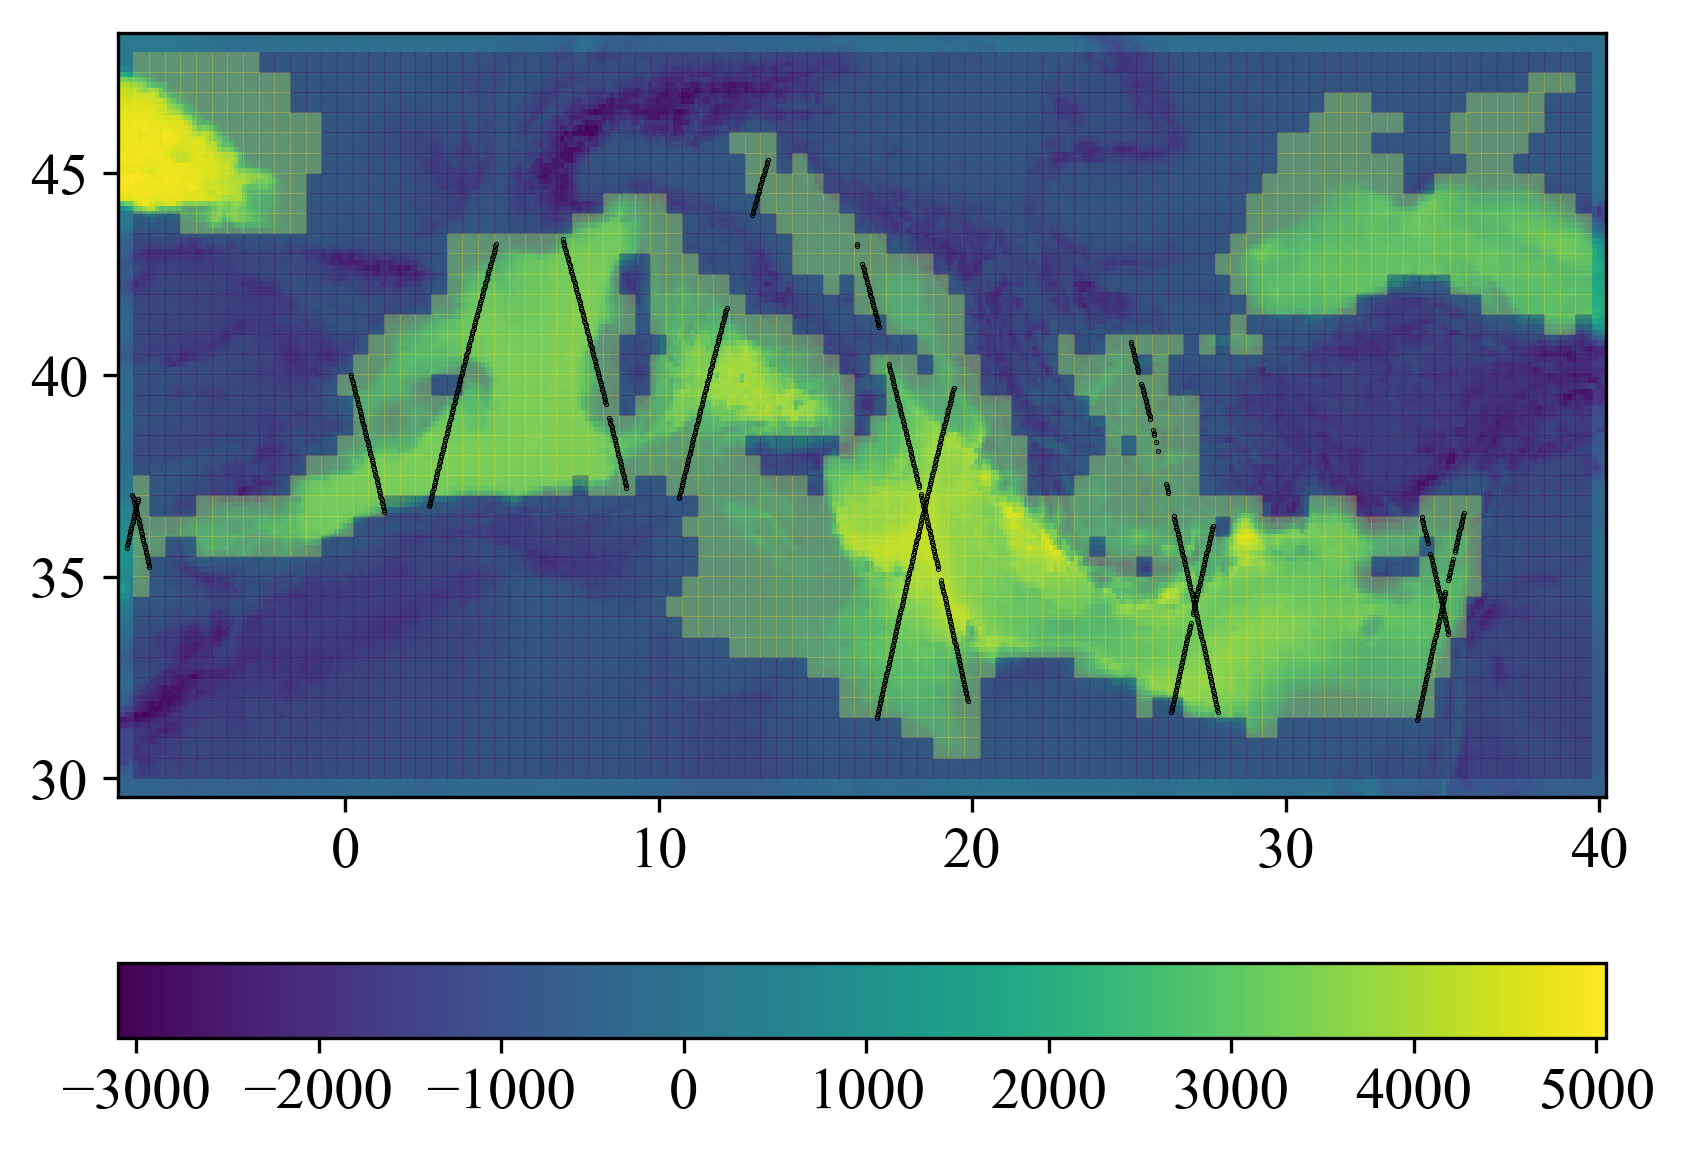

In [15]:
pcolor(bx,by,b'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
plot(obslon, obslat, "ko", markersize=.25)
pcolor(xmask,ymask,Float64.(mmask[:,:,1])', alpha=.25); 

## Analysis parameters

In [16]:
sz = (length(lonr),length(latr),length(timer));
lenx = fill(100_000.,sz); # 100 km
leny = fill(100_000.,sz); # 100 km
lent = fill(5. * 86400.,sz); # 5 days
len = (lenx, leny, lent);

In [17]:
epsilon2 = 0.01;

0.01

In [18]:
typeof(obstimesec.data)

Array{Float64,1}

In [19]:
@time fi,s = divandrun(mask0, (px, py, pt), 
    (xi, yi, ti), (obslon.data, obslat.data, obstimesec.data), obsval.data-mean(obsval.data), len, epsilon2);

INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix


LoadError: [91mBase.LinAlg.PosDefException(95650)[39m